In [1]:
%matplotlib notebook

In [2]:
import polars as pl
import numpy as np
import pandas as pd 

from sklearn.preprocessing import LabelEncoder

import os

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

In [3]:
print(os.listdir("../Home_Credit_Risk_Model_Stability/home-credit-credit-risk-model-stability"))

['feature_definitions.csv', '.DS_Store', 'csv_files', 'parquet_files', 'sample_submission.csv']


In [4]:
# reading the training data
path = ('../Home_Credit_Risk_Model_Stability/home-credit-credit-risk-model-stability/')

In [5]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    # implement here all desired dtypes for tables
    # the following is just an example
    for clm in df.columns:
        # last letter of column name will help you determine the type
        if clm[-1] in ("P", "A"):
            df = df.with_columns(pl.col(clm).cast(pl.Float64).alias(clm))

    return df

In [6]:
def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:  
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

In [7]:
# checking missing data
def counting_null_values(df: pl.DataFrame) -> pl.DataFrame:
    total = 0
    
    for col in df.columns: 
        total += df.select(pl.col(col)).null_count()
    
    return(total)


In [8]:
train_basetable = pl.read_csv(path + "csv_files/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(path + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(path + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(path + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(path + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes) 
train_credit_bureau_b_2 = pl.read_csv(path + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes) 
applprev_1 = pl.concat(
    [
        pl.read_csv(path + "csv_files/train/train_applprev_1_0.csv").pipe(set_table_dtypes),
        pl.read_csv(path + "csv_files/train/train_applprev_1_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
other_1 = pl.read_csv(path + "csv_files/train/train_other_1.csv").pipe(set_table_dtypes)
tax_registry_a_1 = pl.read_csv(path + "csv_files/train/train_tax_registry_a_1.csv").pipe(set_table_dtypes)
tax_registry_b_1 = pl.read_csv(path + "csv_files/train/train_tax_registry_b_1.csv").pipe(set_table_dtypes)
tax_registry_c_1 = pl.read_csv(path + "csv_files/train/train_tax_registry_c_1.csv").pipe(set_table_dtypes)
credit_bureau_b_1 = pl.read_csv(path + "csv_files/train/train_credit_bureau_b_1.csv").pipe(set_table_dtypes)
deposit_1 = pl.read_csv(path + "csv_files/train/train_deposit_1.csv").pipe(set_table_dtypes)
person_1 = pl.read_csv(path + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes)
debitcard_1 = pl.read_csv(path + "csv_files/train/train_debitcard_1.csv").pipe(set_table_dtypes)
applprev_2 = pl.read_csv(path + "csv_files/train/train_applprev_2.csv").pipe(set_table_dtypes)
person_2 = pl.read_csv(path + "csv_files/train/train_person_2.csv").pipe(set_table_dtypes)

In [9]:
dataset_names = [train_basetable , train_static, train_static_cb, train_person_1, train_credit_bureau_b_2, applprev_1, 
                other_1, tax_registry_a_1, tax_registry_b_1, tax_registry_c_1, credit_bureau_b_1, deposit_1,
                person_1, debitcard_1, applprev_2, person_2]
dataset_names_str = ['train_basetable' , 'train_static', 'train_static_cb', 'train_person_1',
                     'train_credit_bureau_b_2','applprev_1', 'other_1', 'tax_registry_a_1', 
                     'tax_registry_b_1', 'tax_registry_c_1', 'credit_bureau_b_1',
                     'deposit_1','person_1', 'debitcard_1', 'applprev_2', 'person_2']
null_value_count = []

for dataset in dataset_names:
    null_value_count.append(pl.lit(dataset.pipe(counting_null_values))) 
    
null_dataset_train = pl.DataFrame(
    {
        "Dataset_Names": dataset_names_str,
        "Null_Value_Count": null_value_count
         
    }
)
null_dataset_train

Dataset_Names,Null_Value_Count
str,object
"""train_basetabl…",0
"""train_static""",78503607
"""train_static_c…",49375701
"""train_person_1…",51051536
"""train_credit_b…",10722
…,…
"""deposit_1""",79682
"""person_1""",51051536
"""debitcard_1""",450239


In [10]:
credit_bureau_a_1 = pl.concat(
    [
        pl.read_csv(path + "csv_files/train/train_credit_bureau_a_1_0.csv").pipe(set_table_dtypes),
        pl.read_csv(path + "csv_files/train/train_credit_bureau_a_1_1.csv").pipe(set_table_dtypes),
#         pl.read_csv(path + "csv_files/train/train_credit_bureau_a_1_2.csv").pipe(set_table_dtypes),
#         pl.read_csv(path + "csv_files/train/train_credit_bureau_a_1_3.csv").pipe(set_table_dtypes),

    ],
    how="vertical_relaxed",
)

credit_bureau_a_2 = pl.concat(
    [
        pl.read_csv(path + "csv_files/train/train_credit_bureau_a_2_0.csv").pipe(set_table_dtypes),
        pl.read_csv(path + "csv_files/train/train_credit_bureau_a_2_1.csv").pipe(set_table_dtypes),
#         pl.read_csv(path + "csv_files/train/train_credit_bureau_a_2_2.csv").pipe(set_table_dtypes),
#         pl.read_csv(path + "csv_files/train/train_credit_bureau_a_2_3.csv").pipe(set_table_dtypes),
#         pl.read_csv(path + "csv_files/train/train_credit_bureau_a_2_4.csv").pipe(set_table_dtypes),
#         pl.read_csv(path + "csv_files/train/train_credit_bureau_a_2_5.csv").pipe(set_table_dtypes),
#         pl.read_csv(path + "csv_files/train/train_credit_bureau_a_2_6.csv").pipe(set_table_dtypes),
#         pl.read_csv(path + "csv_files/train/train_credit_bureau_a_2_7.csv").pipe(set_table_dtypes),
#         pl.read_csv(path + "csv_files/train/train_credit_bureau_a_2_8.csv").pipe(set_table_dtypes),
#         pl.read_csv(path + "csv_files/train/train_credit_bureau_a_2_9.csv").pipe(set_table_dtypes),
#         pl.read_csv(path + "csv_files/train/train_credit_bureau_a_2_10.csv").pipe(set_table_dtypes),


    ],
    how="vertical_relaxed",
)


# Explore the Train Datasets

In [11]:
train_basetable.head()

case_id,date_decision,MONTH,WEEK_NUM,target
i64,str,i64,i64,i64
0,"""2019-01-03""",201901,0,0
1,"""2019-01-03""",201901,0,0
2,"""2019-01-04""",201901,0,0
3,"""2019-01-03""",201901,0,0
4,"""2019-01-04""",201901,0,1


In [12]:
train_static.head()

case_id,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_136L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,…,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,payvacationpostpone_4187118D,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,previouscontdistrict_112M,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,typesuite_864L,validfrom_1069D
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,…,str,str,f64,f64,str,f64,str,f64,str,f64,f64,f64,bool,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str
0,null,null,1917.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,null,"""OTHER""","""OTHER""",null,null,null,null,null,null,24.0,0.0,0.0,null,"""a55475b1""",null,0.0,0.0,null,null,0.0,0.0,null,"""BO""",null,null
1,null,null,3134.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0.0""",3.0,0.0,0.0,0.0,0.0,0.0,0.0,…,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,null,"""OTHER""","""OTHER""",null,null,null,null,null,null,18.0,0.0,0.0,null,"""a55475b1""",null,0.0,0.0,null,null,0.0,0.0,null,"""BO""",null,null
2,null,null,4937.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,false,"""OTHER""","""OTHER""",null,null,null,null,null,null,36.0,0.0,0.0,null,"""a55475b1""",null,0.0,0.0,null,null,0.0,0.0,null,"""BO""","""AL""",null
3,null,null,4643.6,0.0,0.0,1.0,0.0,2.0,0.0,1.0,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,1.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,null,null,null,null,null,null,null,null,null,0.0,0.0,1.0,false,"""OTHER""","""OTHER""",null,null,null,null,null,null,12.0,0.0,0.0,null,"""a55475b1""",null,1.0,1.0,null,null,0.0,0.0,null,"""BO""","""AL""",null
4,null,null,3390.2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,false,"""OTHER""","""OTHER""",null,null,null,null,null,null,24.0,0.0,0.0,null,"""a55475b1""",null,0.0,0.0,null,null,0.0,0.0,null,"""BO""","""AL""",null


In [13]:
train_static_cb.head()

case_id,assignmentdate_238D,assignmentdate_4527235D,assignmentdate_4955616D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,dateofbirth_342D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,for3years_128L,for3years_504L,for3years_584L,formonth_118L,formonth_206L,formonth_535L,forquarter_1017L,forquarter_462L,forquarter_634L,fortoday_1092L,forweek_1077L,forweek_528L,forweek_601L,foryear_618L,foryear_818L,foryear_850L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtcount_4527229L,pmtcount_4955617L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,riskassesment_302T,riskassesment_940T,secondquarter_766L,thirdquarter_1082L
i64,str,str,str,str,str,str,str,f64,f64,f64,f64,f64,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,str,str,str,str,str,f64,f64,f64
357,null,null,null,"""1988-04-01""",null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,6.0,6301.4,null,"""2019-01-25""",null,null,null,null,null,null
381,null,null,null,"""1973-11-01""",null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,6.0,4019.6,null,"""2019-01-25""",null,null,null,null,null,null
388,null,null,null,"""1989-04-01""",null,"""1989-04-01""",null,6.0,8.0,2.0,10.0,4.0,"""a55475b1""","""a55475b1""","""a55475b1""",2.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,6.0,"""a55475b1""","""a55475b1""",10.0,null,null,null,null,null,null,6.0,14548.0,null,"""2019-01-28""",null,null,null,null,3.0,5.0
405,null,null,null,"""1974-03-01""",null,"""1974-03-01""",null,0.0,0.0,0.0,1.0,0.0,"""a55475b1""","""a55475b1""","""a55475b1""",0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4.0,"""a55475b1""","""a55475b1""",1.0,null,null,null,null,null,null,6.0,10498.24,null,"""2019-01-21""",null,null,null,null,2.0,0.0
409,null,null,null,"""1993-06-01""",null,"""1993-06-01""",null,2.0,3.0,0.0,3.0,1.0,"""a55475b1""","""717ddd49""","""a55475b1""",4.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0,"""a7fcb6e5""","""a55475b1""",3.0,null,null,null,null,null,null,7.0,6344.8804,null,"""2019-01-21""",null,null,null,null,0.0,4.0


In [14]:
train_person_1.head()

case_id,birth_259D,birthdate_87D,childnum_185L,contaddr_district_15M,contaddr_matchlist_1032L,contaddr_smempladdr_334L,contaddr_zipcode_807M,education_927M,empl_employedfrom_271D,empl_employedtotal_800L,empl_industry_691L,empladdr_district_926M,empladdr_zipcode_114M,familystate_447L,gender_992L,housetype_905L,housingtype_772L,incometype_1044T,isreference_387L,language1_981M,mainoccupationinc_384A,maritalst_703L,num_group1,personindex_1023L,persontype_1072L,persontype_792L,registaddr_district_1083M,registaddr_zipcode_184M,relationshiptoclient_415T,relationshiptoclient_642T,remitter_829L,role_1084L,role_993L,safeguarantyflag_411L,sex_738L,type_25L
i64,str,str,f64,str,bool,bool,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,f64,str,i64,f64,f64,f64,str,str,str,str,bool,str,str,bool,str,str
0,"""1986-07-01""",null,null,"""P88_18_84""",false,false,"""P167_100_165""","""P97_36_170""","""2017-09-15""","""MORE_FIVE""","""OTHER""","""P142_57_166""","""P167_100_165""","""MARRIED""",null,null,null,"""SALARIED_GOVT""",null,"""P10_39_147""",10800.0,null,0,0.0,1.0,1.0,"""P88_18_84""","""P167_100_165""",null,null,null,"""CL""",null,true,"""F""","""PRIMARY_MOBILE…"
0,null,null,null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,"""a55475b1""",null,null,1,1.0,1.0,4.0,"""a55475b1""","""a55475b1""","""SPOUSE""",null,false,"""EM""",null,null,null,"""PHONE"""
0,null,null,null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,"""a55475b1""",null,null,2,2.0,4.0,5.0,"""a55475b1""","""a55475b1""","""COLLEAGUE""","""SPOUSE""",false,"""PE""",null,null,null,"""PHONE"""
0,null,null,null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,"""a55475b1""",null,null,3,null,5.0,null,"""a55475b1""","""a55475b1""",null,"""COLLEAGUE""",null,"""PE""",null,null,null,"""PHONE"""
1,"""1957-08-01""",null,null,"""P103_93_94""",false,false,"""P176_37_166""","""P97_36_170""","""2008-10-29""","""MORE_FIVE""","""OTHER""","""P49_46_174""","""P160_59_140""","""DIVORCED""",null,null,null,"""SALARIED_GOVT""",null,"""P10_39_147""",10000.0,null,0,0.0,1.0,1.0,"""P103_93_94""","""P176_37_166""",null,null,null,"""CL""",null,true,"""M""","""PRIMARY_MOBILE…"


In [15]:
train_credit_bureau_b_2.head()

case_id,num_group1,num_group2,pmts_date_1107D,pmts_dpdvalue_108P,pmts_pmtsoverdue_635A
i64,i64,i64,str,f64,f64
467,0,0,"""2018-11-15""",null,null
467,0,1,"""2018-12-15""",null,null
467,1,0,"""2018-12-15""",null,null
467,2,0,"""2016-10-15""",0.0,0.0
467,2,1,"""2016-11-15""",0.0,0.0


In [16]:
applprev_1.head()

case_id,actualdpd_943P,annuity_853A,approvaldate_319D,byoccupationinc_3656910L,cancelreason_3545846M,childnum_21L,creationdate_885D,credacc_actualbalance_314A,credacc_credlmt_575A,credacc_maxhisbal_375A,credacc_minhisbal_90A,credacc_status_367L,credacc_transactions_402L,credamount_590A,credtype_587L,currdebt_94A,dateactivated_425D,district_544M,downpmt_134A,dtlastpmt_581D,dtlastpmtallstes_3545839D,education_1138M,employedfrom_700D,familystate_726L,firstnonzeroinstldate_307D,inittransactioncode_279L,isbidproduct_390L,isdebitcard_527L,mainoccupationinc_437A,maxdpdtolerance_577P,num_group1,outstandingdebt_522A,pmtnum_8L,postype_4733339M,profession_152M,rejectreason_755M,rejectreasonclient_4145042M,revolvingaccount_394A,status_219L,tenor_203L
i64,f64,f64,str,f64,str,f64,str,f64,f64,f64,f64,str,f64,f64,str,f64,str,str,f64,str,str,str,str,str,str,str,bool,bool,f64,f64,i64,f64,f64,str,str,str,str,f64,str,f64
2,0.0,640.2,null,null,"""a55475b1""",0.0,"""2013-04-03""",null,0.0,null,null,null,null,10000.0,"""CAL""",null,null,"""P136_108_173""",0.0,null,null,"""P97_36_170""","""2010-02-15""","""SINGLE""","""2013-05-04""","""CASH""",false,null,8200.0,null,0,null,24.0,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""D""",24.0
2,0.0,1682.4,null,null,"""a55475b1""",0.0,"""2013-04-03""",null,0.0,null,null,null,null,16000.0,"""CAL""",null,null,"""P136_108_173""",0.0,null,null,"""P97_36_170""","""2010-02-15""","""SINGLE""","""2013-05-04""","""CASH""",false,null,8200.0,null,1,null,12.0,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""D""",12.0
3,0.0,6140.0,null,null,"""P94_109_143""",null,"""2019-01-07""",null,0.0,null,null,null,null,59999.8,"""CAL""",null,null,"""P131_33_167""",0.0,null,null,"""P97_36_170""","""2018-05-15""","""MARRIED""","""2019-02-07""","""CASH""",false,null,11000.0,null,0,null,12.0,"""a55475b1""","""a55475b1""","""P94_109_143""","""a55475b1""",null,"""D""",12.0
4,0.0,2556.6,null,null,"""P24_27_36""",null,"""2019-01-08""",null,0.0,null,null,null,null,40000.0,"""CAL""",null,null,"""P194_82_174""",0.0,null,null,"""a55475b1""",null,null,"""2019-02-08""","""CASH""",false,null,16000.0,null,0,null,24.0,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""T""",24.0
5,0.0,null,null,null,"""P85_114_140""",null,"""2019-01-16""",null,null,null,null,null,null,null,null,null,null,"""P54_133_26""",null,null,null,"""a55475b1""",null,null,null,null,false,null,62000.0,null,0,null,null,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""T""",null


In [17]:
other_1.head()

case_id,amtdebitincoming_4809443A,amtdebitoutgoing_4809440A,amtdepositbalance_4809441A,amtdepositincoming_4809444A,amtdepositoutgoing_4809442A,num_group1
i64,f64,f64,f64,f64,f64,i64
43801,12466.601,12291.2,914.2,0.0,304.80002,0
43991,3333.4001,3273.4001,0.0,0.0,0.0,0
44001,10000.0,10000.0,0.0,0.0,0.0,0
44053,0.0,0.0,2586.4001,0.0,88.8,0
44130,63.8,60.8,0.0,0.0,0.0,0


In [18]:
tax_registry_a_1.head()

case_id,amount_4527230A,name_4527232M,num_group1,recorddate_4527225D
i64,f64,str,i64,str
28631,711.0,"""f980a1ea""",3,"""2019-09-13"""
28631,1946.0,"""f980a1ea""",2,"""2019-09-13"""
28631,2600.0,"""f980a1ea""",1,"""2019-09-13"""
28631,3616.4001,"""f980a1ea""",0,"""2019-09-13"""
28632,400.0,"""5f9b74f5""",6,"""2019-09-13"""


In [19]:
tax_registry_b_1.head()

case_id,amount_4917619A,deductiondate_4917603D,name_4917606M,num_group1
i64,f64,str,str,i64
49435,6885.0,"""2019-10-16""","""6b730375""",0
49435,6885.0,"""2019-10-16""","""6b730375""",1
49435,6885.0,"""2019-10-16""","""6b730375""",2
49435,6885.0,"""2019-10-16""","""6b730375""",3
49435,6885.0,"""2019-10-16""","""6b730375""",4


In [20]:
tax_registry_c_1.head()

case_id,employername_160M,num_group1,pmtamount_36A,processingdate_168D
i64,str,i64,f64,str
357,"""c91b12ff""",0,1200.0,"""2019-01-04"""
357,"""c91b12ff""",1,1200.0,"""2018-11-28"""
357,"""c91b12ff""",2,972.8,"""2018-11-01"""
357,"""c91b12ff""",3,628.60004,"""2018-10-08"""
357,"""c91b12ff""",4,1200.0,"""2018-09-10"""


In [21]:
credit_bureau_b_1.head()

case_id,amount_1115A,classificationofcontr_1114M,contractdate_551D,contractmaturitydate_151D,contractst_516M,contracttype_653M,credlmt_1052A,credlmt_228A,credlmt_3940954A,credor_3940957M,credquantity_1099L,credquantity_984L,debtpastduevalue_732A,debtvalue_227A,dpd_550P,dpd_733P,dpdmax_851P,dpdmaxdatemonth_804T,dpdmaxdateyear_742T,installmentamount_644A,installmentamount_833A,instlamount_892A,interesteffectiverate_369L,interestrateyearly_538L,lastupdate_260D,maxdebtpduevalodued_3940955A,num_group1,numberofinstls_810L,overdueamountmax_950A,overdueamountmaxdatemonth_494T,overdueamountmaxdateyear_432T,periodicityofpmts_997L,periodicityofpmts_997M,pmtdaysoverdue_1135P,pmtmethod_731M,pmtnumpending_403L,purposeofcred_722M,residualamount_1093A,residualamount_127A,residualamount_3940956A,subjectrole_326M,subjectrole_43M,totalamount_503A,totalamount_881A
i64,f64,str,str,str,str,str,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,i64,f64,f64,f64,f64,str,str,f64,str,f64,str,f64,f64,f64,str,str,f64,f64
467,78000.0,"""ea6782cc""","""2016-10-25""","""2019-10-25""","""7241344e""","""4257cbed""",null,null,null,"""c5a72b57""",null,null,0.0,26571.969,null,null,0.0,11.0,2016.0,null,null,2898.76,null,null,"""2019-01-10""",0.0,2,36.0,0.0,11.0,2016.0,null,"""a0b598e4""",0.0,"""e914c86c""",10.0,"""96a8fdfe""",null,null,null,"""a55475b1""","""a55475b1""",null,null
467,null,"""ea6782cc""","""2011-06-15""","""2031-06-13""","""7241344e""","""724be82a""",3e6,10000.0,3e6,"""P164_34_168""",2.0,1.0,null,null,0.0,0.0,null,null,null,0.0,0.0,null,null,null,"""2019-01-20""",null,0,null,null,null,null,null,"""a55475b1""",null,"""a55475b1""",null,"""96a8fdfe""",0.0,0.0,null,"""fa4f56f1""","""ab3c25cf""",3e6,10000.0
467,null,"""ea6782cc""","""2019-01-04""","""2021-08-04""","""7241344e""","""724be82a""",null,null,130365.0,"""P164_34_168""",1.0,2.0,null,null,0.0,0.0,null,null,null,0.0,26571.969,null,null,null,"""2019-01-20""",null,1,null,null,null,null,null,"""a55475b1""",null,"""a55475b1""",null,"""96a8fdfe""",null,null,null,"""ab3c25cf""","""ab3c25cf""",78000.0,960000.0
1445,12000.0,"""ea6782cc""","""2018-12-31""","""2019-01-29""","""7241344e""","""4257cbed""",null,null,null,"""0aebc0bb""",null,null,0.0,19066.64,null,null,0.0,1.0,2019.0,null,null,19571.412,null,null,"""2019-01-27""",0.0,2,1.0,0.0,1.0,2019.0,null,"""d479a207""",0.0,"""dbcbe8f8""",1.0,"""96a8fdfe""",null,null,null,"""a55475b1""","""a55475b1""",null,null
1445,31400.0,"""01f63ac8""","""2018-07-25""","""2019-12-25""","""7241344e""","""4257cbed""",null,null,null,"""50babcd4""",null,null,0.0,23390.16,null,null,0.0,8.0,2018.0,null,null,2124.142,null,null,"""2019-01-28""",0.0,3,17.0,0.0,8.0,2018.0,null,"""a0b598e4""",0.0,"""dbcbe8f8""",12.0,"""60c73645""",null,null,null,"""a55475b1""","""a55475b1""",null,null


In [22]:
deposit_1.head()

case_id,amount_416A,contractenddate_991D,num_group1,openingdate_313D
i64,f64,str,i64,str
225,0.0,null,0,"""2016-08-16"""
331,260.374,"""2018-03-18""",0,"""2015-03-19"""
358,0.0,null,0,"""2014-09-02"""
390,203.602,"""2017-09-30""",1,"""2015-10-01"""
390,223.68001,null,2,"""2016-06-08"""


In [23]:
person_1.head()

case_id,birth_259D,birthdate_87D,childnum_185L,contaddr_district_15M,contaddr_matchlist_1032L,contaddr_smempladdr_334L,contaddr_zipcode_807M,education_927M,empl_employedfrom_271D,empl_employedtotal_800L,empl_industry_691L,empladdr_district_926M,empladdr_zipcode_114M,familystate_447L,gender_992L,housetype_905L,housingtype_772L,incometype_1044T,isreference_387L,language1_981M,mainoccupationinc_384A,maritalst_703L,num_group1,personindex_1023L,persontype_1072L,persontype_792L,registaddr_district_1083M,registaddr_zipcode_184M,relationshiptoclient_415T,relationshiptoclient_642T,remitter_829L,role_1084L,role_993L,safeguarantyflag_411L,sex_738L,type_25L
i64,str,str,f64,str,bool,bool,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,f64,str,i64,f64,f64,f64,str,str,str,str,bool,str,str,bool,str,str
0,"""1986-07-01""",null,null,"""P88_18_84""",false,false,"""P167_100_165""","""P97_36_170""","""2017-09-15""","""MORE_FIVE""","""OTHER""","""P142_57_166""","""P167_100_165""","""MARRIED""",null,null,null,"""SALARIED_GOVT""",null,"""P10_39_147""",10800.0,null,0,0.0,1.0,1.0,"""P88_18_84""","""P167_100_165""",null,null,null,"""CL""",null,true,"""F""","""PRIMARY_MOBILE…"
0,null,null,null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,"""a55475b1""",null,null,1,1.0,1.0,4.0,"""a55475b1""","""a55475b1""","""SPOUSE""",null,false,"""EM""",null,null,null,"""PHONE"""
0,null,null,null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,"""a55475b1""",null,null,2,2.0,4.0,5.0,"""a55475b1""","""a55475b1""","""COLLEAGUE""","""SPOUSE""",false,"""PE""",null,null,null,"""PHONE"""
0,null,null,null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,"""a55475b1""",null,null,3,null,5.0,null,"""a55475b1""","""a55475b1""",null,"""COLLEAGUE""",null,"""PE""",null,null,null,"""PHONE"""
1,"""1957-08-01""",null,null,"""P103_93_94""",false,false,"""P176_37_166""","""P97_36_170""","""2008-10-29""","""MORE_FIVE""","""OTHER""","""P49_46_174""","""P160_59_140""","""DIVORCED""",null,null,null,"""SALARIED_GOVT""",null,"""P10_39_147""",10000.0,null,0,0.0,1.0,1.0,"""P103_93_94""","""P176_37_166""",null,null,null,"""CL""",null,true,"""M""","""PRIMARY_MOBILE…"


In [24]:
debitcard_1.head()

case_id,last180dayaveragebalance_704A,last180dayturnover_1134A,last30dayturnover_651A,num_group1,openingdate_857D
i64,f64,f64,f64,i64,str
225,null,null,null,0,"""2016-08-16"""
331,null,null,null,0,"""2015-03-19"""
358,null,null,null,0,"""2014-09-02"""
390,null,null,null,0,"""2014-07-23"""
390,null,null,null,1,"""2015-10-01"""


In [25]:
applprev_2.head()

case_id,cacccardblochreas_147M,conts_type_509L,credacc_cards_status_52L,num_group1,num_group2
i64,str,str,str,i64,i64
2,null,"""PRIMARY_MOBILE…",null,0,0
2,null,"""EMPLOYMENT_PHO…",null,0,1
2,null,"""PRIMARY_MOBILE…",null,1,0
2,null,"""EMPLOYMENT_PHO…",null,1,1
3,null,"""PHONE""",null,0,0


In [26]:
person_2.head()

case_id,addres_district_368M,addres_role_871L,addres_zip_823M,conts_role_79M,empls_economicalst_849M,empls_employedfrom_796D,empls_employer_name_740M,num_group1,num_group2,relatedpersons_role_762T
i64,str,str,str,str,str,str,str,i64,i64,str
5,"""a55475b1""",null,"""a55475b1""","""a55475b1""","""a55475b1""",null,"""a55475b1""",0,0,null
6,"""P55_110_32""","""CONTACT""","""P10_68_40""","""P38_92_157""","""P164_110_33""",null,"""a55475b1""",0,0,null
6,"""P55_110_32""","""PERMANENT""","""P10_68_40""","""a55475b1""","""a55475b1""",null,"""a55475b1""",0,1,null
6,"""P204_92_178""","""CONTACT""","""P65_136_169""","""P38_92_157""","""P164_110_33""",null,"""a55475b1""",1,0,"""OTHER_RELATIVE…"
6,"""P191_109_75""","""CONTACT""","""P10_68_40""","""P7_147_157""","""a55475b1""",null,"""a55475b1""",1,1,"""OTHER_RELATIVE…"


In [27]:
credit_bureau_a_1.head()

case_id,annualeffectiverate_199L,annualeffectiverate_63L,classificationofcontr_13M,classificationofcontr_400M,contractst_545M,contractst_964M,contractsum_5085717L,credlmt_230A,credlmt_935A,dateofcredend_289D,dateofcredend_353D,dateofcredstart_181D,dateofcredstart_739D,dateofrealrepmt_138D,debtoutstand_525A,debtoverdue_47A,description_351M,dpdmax_139P,dpdmax_757P,dpdmaxdatemonth_442T,dpdmaxdatemonth_89T,dpdmaxdateyear_596T,dpdmaxdateyear_896T,financialinstitution_382M,financialinstitution_591M,instlamount_768A,instlamount_852A,interestrate_508L,lastupdate_1112D,lastupdate_388D,monthlyinstlamount_332A,monthlyinstlamount_674A,nominalrate_281L,nominalrate_498L,num_group1,numberofcontrsvalue_258L,…,numberofoverdueinstlmax_1039L,numberofoverdueinstlmax_1151L,numberofoverdueinstlmaxdat_148D,numberofoverdueinstlmaxdat_641D,numberofoverdueinstls_725L,numberofoverdueinstls_834L,outstandingamount_354A,outstandingamount_362A,overdueamount_31A,overdueamount_659A,overdueamountmax2_14A,overdueamountmax2_398A,overdueamountmax2date_1002D,overdueamountmax2date_1142D,overdueamountmax_155A,overdueamountmax_35A,overdueamountmaxdatemonth_284T,overdueamountmaxdatemonth_365T,overdueamountmaxdateyear_2T,overdueamountmaxdateyear_994T,periodicityofpmts_1102L,periodicityofpmts_837L,prolongationcount_1120L,prolongationcount_599L,purposeofcred_426M,purposeofcred_874M,refreshdate_3813885D,residualamount_488A,residualamount_856A,subjectrole_182M,subjectrole_93M,totalamount_6A,totalamount_996A,totaldebtoverduevalue_178A,totaldebtoverduevalue_718A,totaloutstanddebtvalue_39A,totaloutstanddebtvalue_668A
i64,str,f64,str,str,str,str,str,f64,f64,str,str,str,str,str,f64,f64,str,f64,f64,str,f64,f64,str,str,str,f64,f64,str,str,str,f64,f64,f64,str,i64,f64,…,f64,str,str,str,f64,str,f64,f64,f64,f64,f64,f64,str,str,f64,f64,str,f64,f64,str,str,f64,str,str,str,str,str,f64,f64,str,str,f64,f64,f64,f64,f64,f64
388,null,null,"""ea6782cc""","""a55475b1""","""7241344e""","""a55475b1""",null,null,135806.0,"""2020-08-06""",null,null,"""2018-08-06""",null,null,null,"""a55475b1""",0.0,null,null,8.0,2018.0,null,"""a55475b1""","""P204_66_73""",8742.8,null,null,"""2019-01-11""",null,8742.8,null,null,null,1,null,…,0.0,null,null,null,0.0,null,null,null,null,0.0,0.0,null,null,null,0.0,null,null,8.0,2018.0,null,null,null,null,null,"""60c73645""","""a55475b1""",null,null,114325.805,"""a55475b1""","""a55475b1""",null,null,null,null,null,null
388,null,null,"""4408ff0f""","""a55475b1""","""7241344e""","""a55475b1""",null,null,null,"""2023-06-20""",null,null,"""2018-06-20""",null,374419.5,0.0,"""a55475b1""",0.0,null,null,7.0,2018.0,null,"""a55475b1""","""55b002a9""",null,null,null,"""2019-01-24""",null,7811.4463,null,null,null,0,2.0,…,0.0,null,null,null,0.0,null,null,260093.7,null,0.0,0.0,null,null,null,0.0,null,null,7.0,2018.0,null,null,30.0,null,null,"""96a8fdfe""","""a55475b1""",null,null,null,"""ab3c25cf""","""ab3c25cf""",null,268897.62,0.0,0.0,374419.5,0.0
388,null,null,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,null,"""a55475b1""",null,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,2,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""","""2019-01-28""",null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null
388,null,null,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,null,"""a55475b1""",null,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,3,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""","""2019-01-28""",null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null
388,null,null,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",

In [28]:
credit_bureau_a_2.head()

case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
i64,str,str,f64,str,str,str,i64,i64,f64,f64,f64,str,f64,f64,f64,str,str,str
388,"""8fd95e4b""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",0,0,null,null,2.0,null,null,null,2018.0,null,"""a55475b1""","""ab3c25cf"""
388,"""9a0c095e""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",1,0,null,null,2.0,null,null,null,2018.0,null,"""a55475b1""","""ab3c25cf"""
388,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,1,null,null,3.0,null,null,null,2018.0,null,"""a55475b1""","""a55475b1"""
388,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,2,null,null,4.0,null,null,null,2018.0,null,"""a55475b1""","""a55475b1"""
388,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,3,null,null,5.0,null,null,null,2018.0,null,"""a55475b1""","""a55475b1"""


In [29]:
pmtamount_df = tax_registry_c_1.group_by("case_id", maintain_order=True).agg(pl.sum("pmtamount_36A"))
pmtamount_df

case_id,pmtamount_36A
i64,f64
357,6301.40004
381,4019.60004
388,14548.0001
405,10498.2402
409,6344.879814
…,…
2629807,15803.2002
2629808,23062.0003
2629809,4471.4


<IPython.core.display.Javascript object>


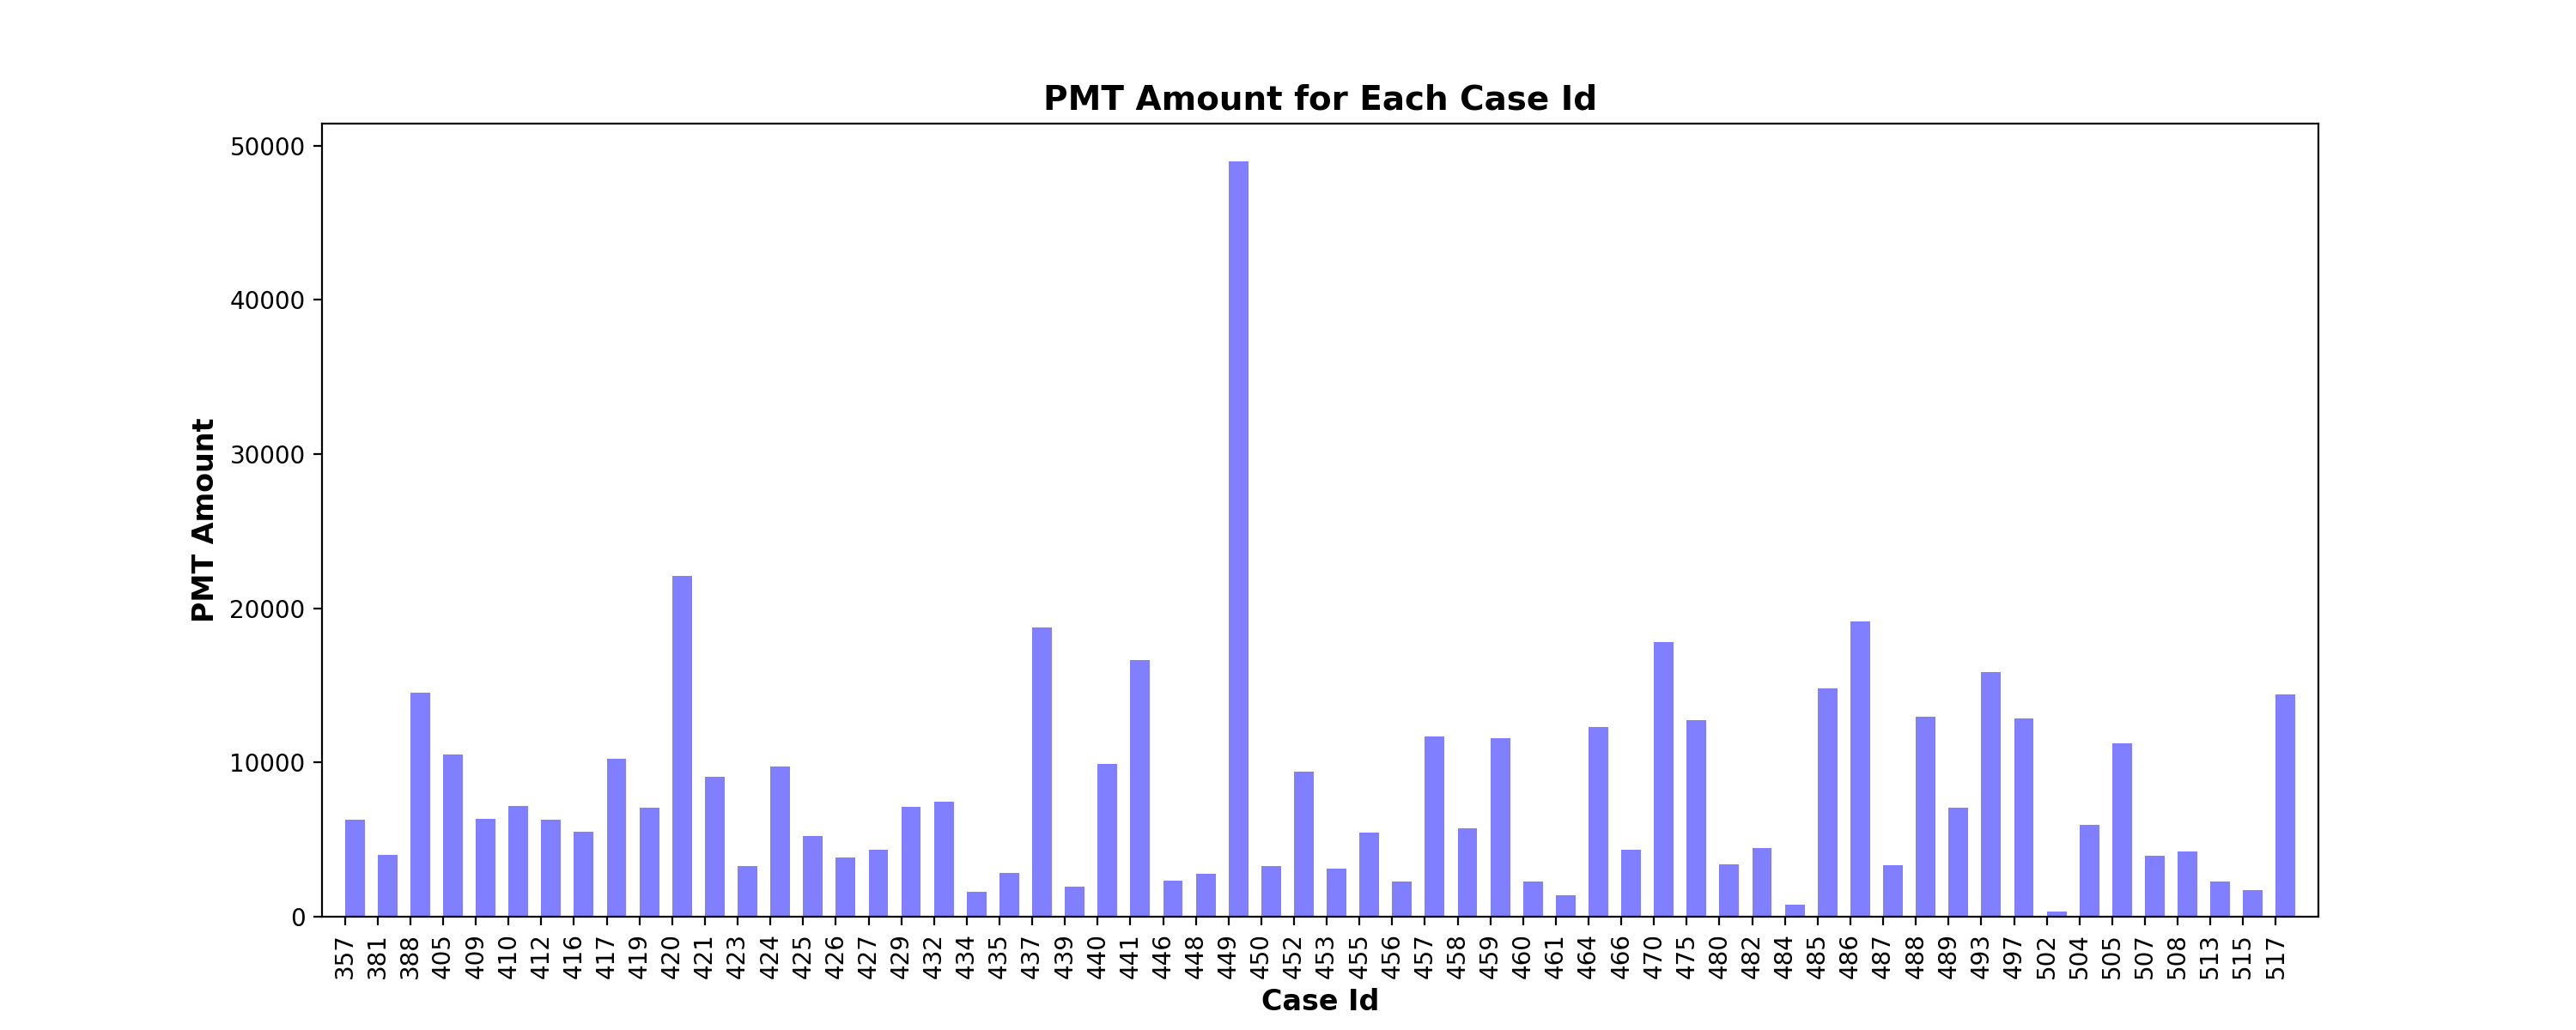

In [30]:
plt.figure(figsize=(15,6))
plt.title("PMT Amount for Each Case Id", fontweight='bold', fontsize=14)
plt.xlabel("Case Id", fontweight='bold', fontsize=12)
plt.ylabel("PMT Amount", fontweight='bold', fontsize=12)

# define data values
x_axis = np.arange(len(pmtamount_df.head(60))) # X-axis points
y_axis = pmtamount_df["pmtamount_36A"].head(60) # Y-axis points

# Width of each bar
bar_width = 0.6

# Spacing between bars
spacing = 0.7
 
plt.bar(x_axis, y_axis, color='b', alpha=0.5, align="edge",width = bar_width)  # Plot the chart
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, pmtamount_df["case_id"].head(60), rotation="vertical")
plt.xlim(x_axis [0] - spacing, x_axis [-1] + bar_width + spacing)
plt.show()

In [31]:
test_basetable = pl.read_csv(path + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(path + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(path + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(path + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(path + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(path + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes) 
test_credit_bureau_b_2 = pl.read_csv(path + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes)
applprev_1 = pl.concat(
    [
        pl.read_csv(path + "csv_files/test/test_applprev_1_0.csv").pipe(set_table_dtypes),
        pl.read_csv(path + "csv_files/test/test_applprev_1_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
other_1 = pl.read_csv(path + "csv_files/test/test_other_1.csv").pipe(set_table_dtypes)
tax_registry_a_1 = pl.read_csv(path + "csv_files/test/test_tax_registry_a_1.csv").pipe(set_table_dtypes)
tax_registry_b_1 = pl.read_csv(path + "csv_files/test/test_tax_registry_b_1.csv").pipe(set_table_dtypes)
tax_registry_c_1 = pl.read_csv(path + "csv_files/test/test_tax_registry_c_1.csv").pipe(set_table_dtypes)
credit_bureau_b_1 = pl.read_csv(path + "csv_files/test/test_credit_bureau_b_1.csv").pipe(set_table_dtypes)
deposit_1 = pl.read_csv(path + "csv_files/test/test_deposit_1.csv").pipe(set_table_dtypes)
person_1 = pl.read_csv(path + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes)
debitcard_1 = pl.read_csv(path + "csv_files/test/test_debitcard_1.csv").pipe(set_table_dtypes)
applprev_2 = pl.read_csv(path + "csv_files/test/test_applprev_2.csv").pipe(set_table_dtypes)
person_2 = pl.read_csv(path + "csv_files/test/test_person_2.csv").pipe(set_table_dtypes)

In [32]:
dataset_names = [test_basetable , test_static, test_static_cb, test_person_1, test_credit_bureau_b_2, applprev_1, 
                other_1, tax_registry_a_1, tax_registry_b_1, tax_registry_c_1, credit_bureau_b_1, deposit_1,
                person_1, debitcard_1, applprev_2, person_2]
dataset_names_str = ['test_basetable' , 'test_static', 'test_static_cb', 'test_person_1',
                     'test_credit_bureau_b_2','applprev_1', 'other_1', 'tax_registry_a_1', 
                     'tax_registry_b_1', 'tax_registry_c_1', 'credit_bureau_b_1',
                     'deposit_1','person_1', 'debitcard_1', 'applprev_2', 'person_2']
null_value_count = []

for dataset in dataset_names:
    null_value_count.append(pl.lit(dataset.pipe(counting_null_values))) 
    
null_dataset_test = pl.DataFrame(
    {
        "Dataset_Names": dataset_names_str,
        "Null_Value_Count": null_value_count
         
    }
)
null_dataset_test

Dataset_Names,Null_Value_Count
str,object
"""test_basetable…",0
"""test_static""",1187
"""test_static_cb…",329
"""test_person_1""",149
"""test_credit_bu…",0
…,…
"""deposit_1""",6
"""person_1""",149
"""debitcard_1""",30


In [33]:
credit_bureau_a_1 = pl.concat(
    [
        pl.read_csv(path + "csv_files/test/test_credit_bureau_a_1_0.csv").pipe(set_table_dtypes),
        pl.read_csv(path + "csv_files/test/test_credit_bureau_a_1_1.csv").pipe(set_table_dtypes),
        pl.read_csv(path + "csv_files/test/test_credit_bureau_a_1_2.csv").pipe(set_table_dtypes),
        pl.read_csv(path + "csv_files/test/test_credit_bureau_a_1_3.csv").pipe(set_table_dtypes),
        pl.read_csv(path + "csv_files/test/test_credit_bureau_a_1_4.csv").pipe(set_table_dtypes),

    ],
    how="vertical_relaxed",
)

credit_bureau_a_2 = pl.concat(
    [
        pl.read_csv(path + "csv_files/test/test_credit_bureau_a_2_0.csv").pipe(set_table_dtypes),
        pl.read_csv(path + "csv_files/test/test_credit_bureau_a_2_1.csv").pipe(set_table_dtypes)
#         pl.read_csv(path + "csv_files/test/test_credit_bureau_a_2_2.csv").pipe(set_table_dtypes),
#         pl.read_csv(path + "csv_files/test/test_credit_bureau_a_2_3.csv").pipe(set_table_dtypes),
#         pl.read_csv(path + "csv_files/test/test_credit_bureau_a_2_4.csv").pipe(set_table_dtypes),
#         pl.read_csv(path + "csv_files/test/test_credit_bureau_a_2_5.csv").pipe(set_table_dtypes),
#         pl.read_csv(path + "csv_files/test/test_credit_bureau_a_2_6.csv").pipe(set_table_dtypes),
#         pl.read_csv(path + "csv_files/test/test_credit_bureau_a_2_7.csv").pipe(set_table_dtypes),
#         pl.read_csv(path + "csv_files/test/test_credit_bureau_a_2_8.csv").pipe(set_table_dtypes),
#         pl.read_csv(path + "csv_files/test/test_credit_bureau_a_2_9.csv").pipe(set_table_dtypes),
#         pl.read_csv(path + "csv_files/test/test_credit_bureau_a_2_10.csv").pipe(set_table_dtypes),
#         pl.read_csv(path + "csv_files/test/test_credit_bureau_a_2_11.csv").pipe(set_table_dtypes),


    ],
    how="vertical_relaxed",
)

